# Code

In [ ]:
!pip install datasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 35.9 MB/s eta 0:00:00


In [ ]:
CUDA_LAUNCH_BLOCKING = "1"

In [ ]:
import torch

from datasets import load_dataset
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Load AG News dataset

train_data = load_dataset('ag_news', split='train[:70%]')
valid_data = load_dataset('ag_news', split='train[70%:]')
test_data = load_dataset('ag_news', split='test')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


In [ ]:
# Tokenize the data

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_tokenized = tokenizer(train_data['text'], padding=True, truncation=True)
train_labels = train_data['label']

valid_tokenized = tokenizer(valid_data['text'], padding=True, truncation=True)
valid_labels = valid_data['label']

test_tokenized = tokenizer(test_data['text'], padding=True, truncation=True)
test_labels = test_data['label']

In [ ]:
# Convert data to Tensors

train_dataset = TensorDataset(torch.tensor(train_tokenized['input_ids']),
                              torch.tensor(train_tokenized['attention_mask']),
                              torch.tensor(train_labels))

valid_dataset = TensorDataset(torch.tensor(valid_tokenized['input_ids']),
                            torch.tensor(valid_tokenized['attention_mask']),
                            torch.tensor(valid_labels))

test_dataset = TensorDataset(torch.tensor(test_tokenized['input_ids']),
                             torch.tensor(test_tokenized['attention_mask']),
                             torch.tensor(test_labels))

In [ ]:
# Create DataLoader objects for the datasets

batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
print("Print the number of data points in the train, test, and validation sets.")

print("Size of the train dataset: %d" % (len(train_loader)))
print("Size of the validation dataset: %d" % (len(valid_loader)))
print("Size of the testing dataset: %d" % (len(test_loader)))

Print the number of data points in the train, test, and validation sets.
Size of the train dataset: 329
Size of the validation dataset: 141
Size of the testing dataset: 30


In [ ]:
# Initialize the model

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [ ]:
# Freeze pre-trained parameters

for name, param in model.named_parameters():                
    if name.startswith('roberta'):
        param.requires_grad = False

In [ ]:
# After freezing the RoBERT weights/biases, print the number of remaining trainable parameters

total_params_frozen = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Remaining number of trainable parameters: %d" % (total_params_frozen))

Remaining number of trainable parameters: 593668


In [ ]:
# Set up the optimizer and the loss function

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss().to(device)

model = model.to(device)

In [ ]:
# Set up the training function

def train(model, train_loader, optimizer, criterion):

  epoch_loss = 0
  epoch_accuracy = 0

  model.train()

  for i, (inputs, attention_masks, labels)  in enumerate(train_loader):

      inputs = inputs.to(device)
      attention_masks = attention_masks.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()

      outputs = model(inputs, attention_mask=attention_masks, labels=labels)
      logits = outputs.logits
      
      loss = criterion(logits, labels)

      predictions = torch.argmax(logits, dim=-1)
      accuracy = (predictions == labels).float().mean()

      loss.backward()

      optimizer.step()

      epoch_loss += loss.item()
      epoch_accuracy += accuracy.item()
      
  return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

In [ ]:
# Set up the evaluation function

def evaluate(model, valid_loader, criterion):

  epoch_loss = 0
  epoch_accuracy = 0

  model.eval()

  with torch.no_grad():
    
    for i, (inputs, attention_masks, labels)  in enumerate(valid_loader):

        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs, attention_mask=attention_masks, labels=labels)
        logits = outputs.logits
        
        loss = criterion(logits, labels)

        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()

        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
      
  return epoch_loss / len(valid_loader), epoch_accuracy / len(valid_loader)

In [ ]:
# Train the model on the train set

N_EPOCHS = 3

best_valid_loss = float('inf')
best_model = None

for epoch in range(N_EPOCHS):
        
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model = model
        torch.save(model.state_dict(), 'model.pt')

    print(f'Epoch: {epoch+1:1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy*100:.2f}%')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation Accuracy: {valid_accuracy*100:.2f}%')

Epoch: 1
	Train Loss: 0.516 | Train Accuracy: 83.36%
	Validation Loss: 0.287 | Validation Accuracy: 89.84%
Epoch: 2
	Train Loss: 0.383 | Train Accuracy: 86.94%
	Validation Loss: 0.276 | Validation Accuracy: 90.08%
Epoch: 3
	Train Loss: 0.370 | Train Accuracy: 87.31%
	Validation Loss: 0.267 | Validation Accuracy: 90.61%


In [ ]:
# Set up the testing function

def test(model, test_loader, criterion):

  epoch_loss = 0
  epoch_accuracy = 0
  
  model.eval()

  with torch.no_grad():

    for i, (inputs, attention_masks, labels)  in enumerate(test_loader):

        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
      
        outputs = model(inputs, attention_mask=attention_masks, labels=labels)
        logits = outputs.logits
          
        loss = criterion(logits, labels)

        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()

        output_probs = torch.softmax(logits, dim=1)

        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
      
  return epoch_loss / len(test_loader), epoch_accuracy / len(test_loader)

In [ ]:
# Test the model on the test set

model.load_state_dict(torch.load('model.pt'))

test_loss, test_accuracy = test(model, test_loader, criterion)

print(f'\tTest Loss: {test_loss:.3f} | Test Accuracy: {test_accuracy*100:.2f}%')

	Test Loss: 0.277 | Test Accuracy: 90.59%


In [ ]:
# Get predictions

def get_predictions(model, test_loader):

  model.eval()

  predict_labels = []
  probs = []

  with torch.no_grad():

    for i, (inputs, attention_masks, labels)  in enumerate(test_loader):

        inputs = inputs.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
      
        outputs = model(inputs, attention_mask=attention_masks, labels=labels)
        logits = outputs.logits  
        output_probs = torch.softmax(logits, dim=1)

        predict_labels.append(labels.to("cpu"))
        probs.append(output_probs.to("cpu"))
  
  predict_labels = torch.cat(predict_labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
      
  return predict_labels, probs

In [ ]:
# Calculate additional performance metrics

predict_labels, probs = get_predictions(model, test_loader)

In [ ]:
pred_labels = torch.argmax(probs, 1)

tp = ((pred_labels == predict_labels) & (predict_labels == 0)).float().sum()
fp = ((pred_labels != predict_labels) & (predict_labels == 0)).float().sum()
fn = ((pred_labels != predict_labels) & (predict_labels != 0)).float().sum()
tn = ((pred_labels == predict_labels) & (predict_labels != 0)).float().sum()

accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1_score))

Accuracy: 0.906
Precision: 0.906
Recall: 0.762
F1 Score: 0.828


In [ ]:
# Plot confusion matrix

def plot_confusion_matrix(predict_labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(predict_labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = [0, 1, 2, 3]);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

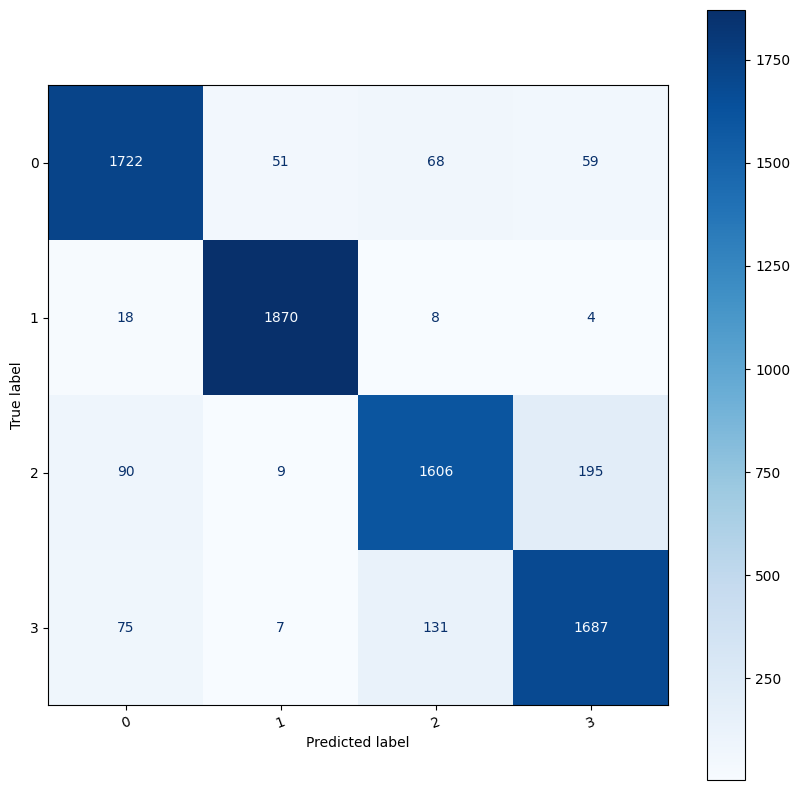

In [ ]:
plot_confusion_matrix(predict_labels, pred_labels) 